## Batted Ball In Play Predictive Model

Import Libraries

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import xgboost as xgb
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, average_precision_score, roc_curve, auc, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn import datasets, metrics, model_selection, svm
from xgboost import plot_importance, XGBClassifier
from pandas import DataFrame

# Import the Data Sets

In [55]:
inplaytraining = pd.read_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\training.csv')
inplaydeploy = pd.read_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\deploy.csv')

# Checking Structure and Summary of the Training Data

I check the structure and summary of the data to get an understsanding of it. I then removed any missing values within the data set.

In [8]:
inplaytraining.head(10)

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
5,0,95.00,2580.0,7.16,16.07
6,0,97.94,2376.0,12.29,18.11
7,0,95.42,2103.0,7.98,10.98
8,0,94.12,2535.0,5.68,18.59
9,0,93.23,2242.0,4.10,16.95


In [9]:
inplaytraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            10000 non-null  int64  
 1   Velo              10000 non-null  float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         10000 non-null  float64
 4   InducedVertBreak  10000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [10]:
inplaytraining.dtypes

InPlay                int64
Velo                float64
SpinRate            float64
HorzBreak           float64
InducedVertBreak    float64
dtype: object

Reviewing and Removing Missing Values from the Data set

In [11]:
inplaytraining.isna().sum()

InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [12]:
inplaytraining = inplaytraining.dropna()

In [13]:
inplaytraining.isna().sum()

InPlay              0
Velo                0
SpinRate            0
HorzBreak           0
InducedVertBreak    0
dtype: int64

# Difference of InPlay Outcomes

Here I checked to see the difference in the outcomes in the variable 'InPlay'. A proper predictive model needs to have an even number of outcomes between 1 and 0 in the dependent variable. If there is an outcome that occurs often, the predictive model will skew towards that outcome. There are 2.6 times the number of 0's as there are 1's. Therefore, I doubled the number of 1's within the data set by copying the rows with InPlay outcome of '1' and concatenated them to the training data set.

In [14]:
InPlay = inplaytraining.loc[inplaytraining['InPlay'] == 1]
InPlay

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
12,1,94.67,2357.0,12.33,12.11
13,1,91.51,2279.0,7.73,19.97
16,1,96.74,1932.0,17.59,8.85
20,1,95.89,2520.0,7.89,18.27
24,1,96.17,2034.0,18.99,4.88
...,...,...,...,...,...
9985,1,93.67,2239.0,8.84,11.07
9989,1,94.47,2328.0,7.07,19.48
9994,1,92.84,2377.0,10.48,18.77
9996,1,90.72,1928.0,14.10,6.08


In [15]:
7278 / 2716

2.6796759941089836

In [16]:
frames = [inplaytraining, InPlay]
inplaytraining = pd.concat(frames)
inplaytraining

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
...,...,...,...,...,...
9985,1,93.67,2239.0,8.84,11.07
9989,1,94.47,2328.0,7.07,19.48
9994,1,92.84,2377.0,10.48,18.77
9996,1,90.72,1928.0,14.10,6.08


# Correlation Plot

I created the correlation plot below to determine if there are any highly correlated attributes. If there were, I would have removed any necessary attribute but as shown below, there was no need to remove any attributes.

In [17]:
corr = inplaytraining.corr()
corr.style.background_gradient(cmap='coolwarm')

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
InPlay,1.000000,-0.057530,-0.073508,0.080989,-0.103943
Velo,-0.057530,1.000000,0.356024,0.005496,0.102138
SpinRate,-0.073508,0.356024,1.000000,-0.249759,0.398054
HorzBreak,0.080989,0.005496,-0.249759,1.000000,-0.575536
InducedVertBreak,-0.103943,0.102138,0.398054,-0.575536,1.000000


# Train Test Split

I split the training data into a train and test set in preparation for the predictive model. 

In [19]:
Target = inplaytraining.InPlay

In [20]:
Target.unique()

array([0, 1], dtype=int64)

In [21]:
Features = inplaytraining.drop('InPlay', axis=1)

In [22]:
Features.head(10)

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,95.33,2893.0,10.68,21.33
1,94.41,2038.0,17.13,5.77
2,90.48,2183.0,6.61,15.39
3,93.04,2279.0,9.33,14.57
4,95.17,2384.0,6.99,17.62
5,95.00,2580.0,7.16,16.07
6,97.94,2376.0,12.29,18.11
7,95.42,2103.0,7.98,10.98
8,94.12,2535.0,5.68,18.59
9,93.23,2242.0,4.10,16.95


In [23]:
x_train, x_test, y_train, y_test = train_test_split(Features, Target, train_size = 0.9, test_size = 0.1, random_state = 3957)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(11439, 4) (1271, 4) (11439,) (1271,)


# Cross Validation Score

The below block of code uses a cross validation score to determine what would be the best model to use to predict the chances of a ball being put in play. I appended five models including; XGBoost, Logistic Regression, Random Forest Classifier and Regression and Decision Tree. The code then shows which model had the highest score showing which is best to use. In this case the Random Forest Classification had the highest score thus making it the best model choice. 

In [24]:
models = []

models.append(("XGB", xgb.XGBClassifier(max_depth = 2, n_estimators = 4, n_jobs = -1)))
models.append(("LogisticRegression", LogisticRegression(max_iter=100)))
models.append(("RandomForestClassification", RandomForestClassifier()))
models.append(("RandomForestRegression", RandomForestRegressor()))
models.append(("DecisionTree", DecisionTreeClassifier()))

results = []
names = []

for name,model in models:
    print("===================================================")
    print(name)
    result = cross_val_score(model, x_train, y_train)
    names.append(name)
    results.append(result)
    
print("===========================================")

for i in range(len(names)):
    print(names[i],results[i].mean())
    


XGB
LogisticRegression
RandomForestClassification
RandomForestRegression
DecisionTree
XGB 0.5777606248146256
LogisticRegression 0.5694553970297302
RandomForestClassification 0.8015571442112762
RandomForestRegression 0.3620528720601198
DecisionTree 0.7316214557196192


# Tuned Random Forest Classification Model

I tuned the Random Forest Classification model to maximize accruacy when predicting batted balls in play. I then predicted the probability of a '0' and '1' InPlay outcomes using the features test set and random forest model.

In [25]:
model = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 100)

In [26]:
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=100)

# Prediction and Sanity Checks

I used the model created above and predicted the probability of a 0 and 1 outcome. The predictions were then placed into a data frame with the columns of Prob_0 and Prob_1 showing the probability of each outcome respectively. I then compared the sum of InPlay actuals ('y_test') and Prob_1 as a sanity check. If the sums are close in output, then I can be confident in the accuracy of the model but if the sums are way off, then the model needs to be reassessed and improved. In this case the sums are close in output, so the model has passed this sanity check. The next sanity check I ran was the accuracy score. The score was 0.885 or the model predicted on an 88.5% accuracy rate thus showing the model passing on the second sanity check. The last check is the Area Under the Curve (AUC) score which is 0.952 or 95.2% showing that the model performed well predicting outputs of 0's and 1's compared to the actuals. 

The Random Forest model created passed all three sanity checks, thus allowing me to be confident in the model output.

In [27]:
pred = model.predict(x_test)
prob = model.predict_proba(x_test)
pred
prob

array([[0.18, 0.82],
       [0.2 , 0.8 ],
       [0.82, 0.18],
       ...,
       [0.34, 0.66],
       [0.22, 0.78],
       [0.14, 0.86]])

In [28]:
prob_model = pd.DataFrame(prob, columns = ['Prob_0', 'Prob_1'])

In [29]:
y_test.sum()

554

In [30]:
prob_model['Prob_1'].sum()

656.1399999999999

In [31]:
acc_score = accuracy_score(y_test, pred)
acc_score

0.8851298190401259

In [32]:
roc_auc_score = roc_auc_score(y_test, prob_model['Prob_1'])
roc_auc_score

0.95206410585623

# ROC Curve

The below chart shows the AUC score. The chart shows how well the model did at predicting the outcomes of 0's and 1's within it generating a curve going from (0,0), moving to the top left and gradually curving to (1,1).

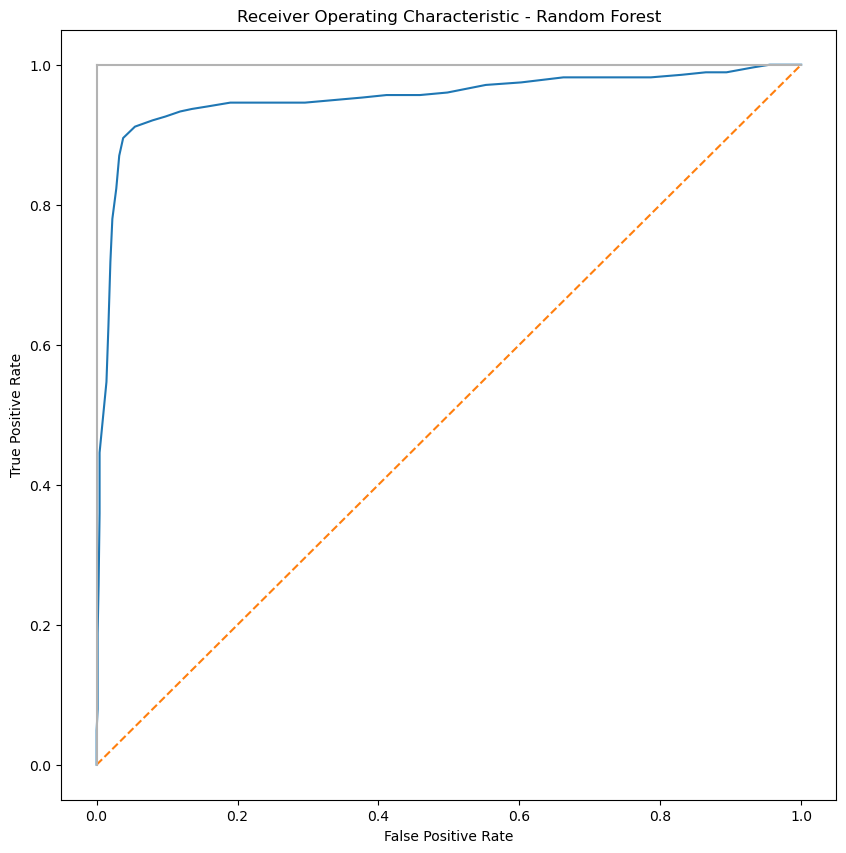

In [33]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, prob_model['Prob_1'])

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
importances = gbm.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Feature Importance Chart

The below chart shows the importance of each feature within the model and how it valued each variable when learning to create predictions. Interestingly enough, it shows that all variables have a near identical importance to the model learning what constitutes an output of a 0 and 1. This would mean that this model shows that there isn't one feature that a pitcher should focus on to prevent batted balls in play. 

Text(0, 0.5, 'Pitch Metrics')

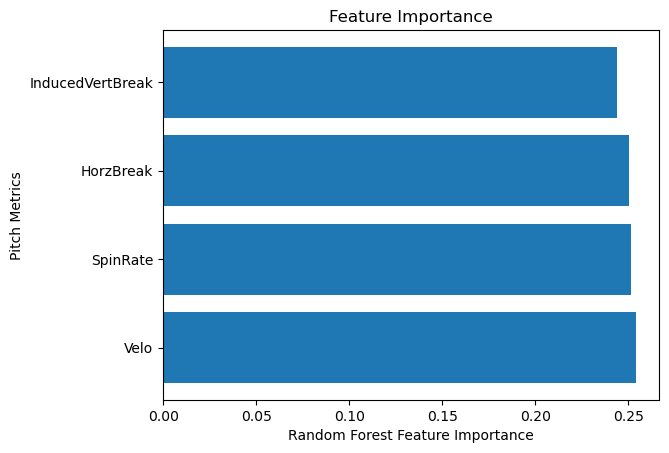

In [53]:
plt.barh(x_train.columns, importances[sorted_indices])
plt.xlabel("Random Forest Feature Importance")
plt.title('Feature Importance')
plt.ylabel('Pitch Metrics')

# Check Summary, Structure and NA Values in Deployment Data

I checked the structure, summary and removed the NA values from the deployment data much like I did for the training data.

In [56]:
inplaydeploy.head(10)

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,94.72,2375.0,3.10,18.15
1,95.25,2033.0,11.26,14.50
2,92.61,2389.0,11.00,21.93
3,94.94,2360.0,6.84,18.11
4,97.42,2214.0,16.70,13.38
5,95.98,2495.0,11.25,17.12
6,94.88,1998.0,15.13,15.22
7,92.73,2049.0,1.55,18.47
8,92.39,1955.0,18.15,7.25
9,95.77,1976.0,10.04,14.56


In [57]:
inplaydeploy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Velo              10000 non-null  float64
 1   SpinRate          9987 non-null   float64
 2   HorzBreak         10000 non-null  float64
 3   InducedVertBreak  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB


In [59]:
inplaydeploy.isna().sum()

Velo                 0
SpinRate            13
HorzBreak            0
InducedVertBreak     0
dtype: int64

In [61]:
inplaydeploy = inplaydeploy.dropna()

In [62]:
inplaydeploy.isna().sum()

Velo                0
SpinRate            0
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [66]:
len(inplaydeploy)

9987

# Predict Values Using Model on Deployment Data

I used the created model to predict batted ball in play outcomes onto the deployment data set and put them into a data fram 'prob_deploy'. I then checked the length of 'prob_deploy' to see if it matches the length of the deployment data set as a sanity check. The length matches thus the sanity check passes and can be merged together using the 'Prob_1' column showing the probability of a 1 occuring. 

In [72]:
prob_deploy = model.predict_proba(inplaydeploy)
prob_deploy

array([[0.72, 0.28],
       [0.68, 0.32],
       [0.82, 0.18],
       ...,
       [0.58, 0.42],
       [0.82, 0.18],
       [0.82, 0.18]])

In [73]:
prob_deploy = pd.DataFrame(prob_deploy, columns = ['Prob_0', 'Prob_1'])

In [74]:
len(prob_deploy)

9987

In [76]:
final_df = pd.merge(inplaydeploy, prob_deploy['Prob_1'], left_index=True, right_index=True, how='left')
final_df.head(30)

,Velo,SpinRate,HorzBreak,InducedVertBreak,Prob_1
0,94.72,2375.0,3.10,18.15,0.28
1,95.25,2033.0,11.26,14.50,0.32
2,92.61,2389.0,11.00,21.93,0.18
3,94.94,2360.0,6.84,18.11,0.48
4,97.42,2214.0,16.70,13.38,0.24
5,95.98,2495.0,11.25,17.12,0.44
6,94.88,1998.0,15.13,15.22,0.24
7,92.73,2049.0,1.55,18.47,0.44
8,92.39,1955.0,18.15,7.25,0.18
9,95.77,1976.0,10.04,14.56,0.08


In [77]:
final_df.to_csv(r'C:\Users\cboat\OneDrive\Documents\In Play Prediction\InPlayPredictionScores.csv')

# Next Steps

The next steps I would take would be to find other variable such as; the location of the pitch, effective velocity, spin axis etc. and look to add them into the model. The more potential variables being introduced to the model would allow it to relearn what is best to predict the probability of balls in play as well as potentially change the feature importance scores. A change in the importance scores would give me a better idea of what pitchers should focus on to limit balls in play. There would be some intricate data cleaning needed as a pitch thrown two feet off the plate would result in a higher chance of it not being put in play, but that pitch results in a negative outcome of a ball. That being said, more variables would allow for a more intricate model and potentially a clearer understanding of what negates a batter's ability of putting a ball in play.